
<p style="background-color:#040C33;font-family:newtimeroman;color:#EFF0F7;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>
<ul style="list-style-type:Upper-roman">
    <li><a href="#1">IMPORT LIBRARIES</a></li>
    <li><a href="#2">Data IMPORT AND LOADING</a></li>
    <li><a href="#3">DATA PREPROCESSING</a></li>
    <ul><li><a href="#4">Training Dataset Preprocessing for Randomization</a></li></ul>
    <ul><li><a href="#4">Validation Dataset</a></li></ul>
    <ul><li><a href="#4">Testing Dataset</a></li></ul>
    <li><a href="#5"> EDA (EXPLORATORY DATA ANALYSIS)</a></li>
    <ul><li><a href="#5"> EDA (EXPLORATORY DATA ANALYSIS)</a></li></ul>
    <ul><li><a href="#5"> Image Visualization</a></li></ul>
    <ul><li><a href="#5"> Training Image Data</a></li></ul>
    <ul><li><a href="#5"> Testing Image Data</a></li></ul>
    <ul><li><a href="#5"> Validating Image Data</a></li></ul>
    <ul><li><a href="#5"> Validating Image Data</a></li></ul>
    <li><a href="#6">IMAGE DATA GENERATION FOR AUGMENTATION</a></li>
    <ul><li><a href="#6"> IMAGE Augmentation Sample</a></li></ul>
    <ul><li><a href="#6"> Data Augmentation and Generation</a></li></ul>
    <li><a href="#7">BUILD MODEL WITH VGG19</a></li>
    <li><a href="#8">MODEL SUMMARY</a></li>
    <li><a href="#9">PLOT MODEL</a></li>
    <li><a href="#10">MODEL COMPILE, TENSORBOARD, CHECKPOINT, REDUCE_LR</a></li>
    <li><a href="#11">MODEL FITTING AND PREDICTION</a></li>
    <li><a href="#12">MODEL EVALUATION</a></li>
    <li><a href="#13">ACCURACY, LEARNING RATE AND LOSS PLOT</a></li>
    <li><a href="#14">MODEL PREDICTION WITH VALIDATION(UNSEEN DATA)</a></li>
    <li><a href="#15">TESTING ACCURACY</a></li>
    <li><a href="#16">AUC and ROC CURVE</a></li>
    <li><a href="#17">CONFUSION MATRIX DISPLAY</a></li>
    <li><a href="#18">MISCLASSIFIED IMAGES</a></li>
    <li><a href="#19">MISCLASSIFIED IMAGE PATH</a></li>
    <li><a href="#20">SUMMARY</a></li>
  

### 👮 About MobileNetV2 Neural Network Model


MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

# 💁 IMPORT LIBRARIES


In [20]:
#openCV
import cv2
#mathmetical operation
import numpy as np
#dataframe
import pandas as pd
#tensorflow for google framework of neural network
import tensorflow as tf
#another library for NN which runs on top of tensorflow for more effecient work and functionality
import keras
#directory access
import os
#data visualization 
#module provides tools and utilities for working with images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as k
#sequential model
#enabling the creation and manipulation of Keras models
from tensorflow.keras.models import Model
#model import
from tensorflow.keras.applications import VGG19
#input details
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
#layer and regularization
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
#activation
from tensorflow.keras.optimizers import  SGD, Adam
#tensorboard
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint, LearningRateScheduler
#model flowchart
from tensorflow.keras.utils import plot_model
#ploting
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid
#misclassification display
import matplotlib.gridspec as gridspec
from PIL import Image

#Accuracy and Confusion Matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
#ROC AUC CURVE
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
from sklearn.preprocessing import label_binarize #for categorical to binary conversion

#Warning
import warnings
from sklearn.exceptions import DataConversionWarning  # Import the specific warning

# Filter specific warnings
warnings.filterwarnings(action='ignore')




# 🌞 DATA IMPORT AND LOADING

`data_dir = ("../cnn/dataset/MRI Image Dataset for Brain Tumor/Training"):` Specifies the root directory containing the dataset. It likely indicates the base directory where the dataset for training, testing, and validation is stored.

`train_dir = os.path.join(data_dir, "Training"):` Creates a path to the training data directory within the dataset. It combines data_dir with a subdirectory named "Training" to point specifically to the directory containing training images. Same for the `test_dir` and `valid_dir`.

These path definitions are useful for organizing and accessing different subsets of the dataset (training, testing, validation) conveniently within a codebase, typically when training machine learning models using these categorized sets of data.

In [21]:
data_dir = ("/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor")
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")
valid_dir = os.path.join(data_dir, "Validation")

In [22]:
#Category name based on subclasses directory in dataset
CATEGORIES =["glioma", "meningioma", "notumor", "pituitary"]
NUM_OF_CATEGORIES = len(CATEGORIES)
NUM_OF_CATEGORIES

4

In [23]:
# Data Information

def data_information(sub_data_dir):
    for category in CATEGORIES:
        print('{} {} images'.format(category,len(os.listdir(os.path.join(sub_data_dir, category)))))

In [25]:
print("\n Training Dataset: \n")
data_information(train_dir)
print("\n Testing Dataset: \n")
data_information(test_dir)
print("\n Validation Dataset: \n")
data_information(valid_dir)



 Training Dataset: 

glioma 1321 images
meningioma 1339 images
notumor 1595 images
pituitary 1457 images

 Testing Dataset: 

glioma 300 images
meningioma 306 images
notumor 405 images
pituitary 300 images

 Validation Dataset: 

glioma 175 images
meningioma 139 images
notumor 162 images
pituitary 179 images


# 🐸 DATA PREPROCESSING

The data_preparation function constructs a Pandas DataFrame by gathering image file paths, category IDs, and category names from a specified dataset_dir. It prints the shape of the resulting dataset and returns the first 5 rows as a summary.

In [26]:
def data_preparation(data, subpath_dir, dataset_dir):
    data_list = []  # Use a different variable name to store collected information
    #tumor category
    for category_id, category in enumerate(CATEGORIES):
        #main_directory + category
        category_dir = os.path.join(dataset_dir, category)
        
        for file in os.listdir(category_dir):
            data_list.append([f'{data_dir}/{subpath_dir}/{category}/{file}', category_id, category])
    
    data = pd.DataFrame(data_list, columns=['file', 'category_id', 'category'])
    print(f'Shape of {subpath_dir} dataset: {data.shape}')
    return data

**📌note:** It's important to join the data path properly to get valid access of image from directory

In [27]:

train = pd.DataFrame()
trainset = data_preparation(train, 'Training', train_dir)
trainset.head(2)

Shape of Training dataset: (5712, 3)


,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma


In [28]:
trainset.iloc[0]['file']

'/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Training/glioma/Tr-gl_0954.jpg'

In [29]:
test = pd.DataFrame()
testset = data_preparation(test, 'Testing', test_dir)
testset.head(2)

Shape of Testing dataset: (1311, 3)


,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma


In [30]:
valid = pd.DataFrame()
validset = data_preparation(valid, 'Validation', valid_dir)
validset.head(2)

Shape of Validation dataset: (655, 3)


,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma


### 🌳 Training Dataset Preprocessing for Randomization

In [31]:
trainset['category'].value_counts()

category
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

In [33]:
#category sampling
SAMPLE_PER_CATEGORIES = 1321
#reproducability
SEED =42
#image re-sizing
WIDTH = 150
HEIGHT =150
#No of channels
DEPTH = 3

INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

**📌Randomization:** Shuffling the data using `sample(frac=1)` randomizes the order of the samples, reducing the impact of any inherent order or bias in the dataset.

In [34]:
training = trainset.copy()
training = pd.concat([training[training['category']==c][:SAMPLE_PER_CATEGORIES] for c in CATEGORIES])
training = training.sample(frac=1)
training.index = np.arange(len(training))
training.shape

(5284, 3)

In [35]:
training.head(10)

,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma
2,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma
3,/kaggle/input/mri-image-based-brain-tumor-clas...,2,notumor
4,/kaggle/input/mri-image-based-brain-tumor-clas...,2,notumor
5,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma
6,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma
7,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma
8,/kaggle/input/mri-image-based-brain-tumor-clas...,2,notumor
9,/kaggle/input/mri-image-based-brain-tumor-clas...,1,meningioma


### 🌳 Validation Dataset

In [36]:
validing = validset.copy()
validing.head(5)

,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
2,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
3,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
4,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma


### 🌳 Testing Dataset

In [37]:
testing = testset.copy()
testing.head(5)

,file,category_id,category
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
2,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
3,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma
4,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma


# 📷 EDA (EXPLORATORY DATA ANALYSIS)

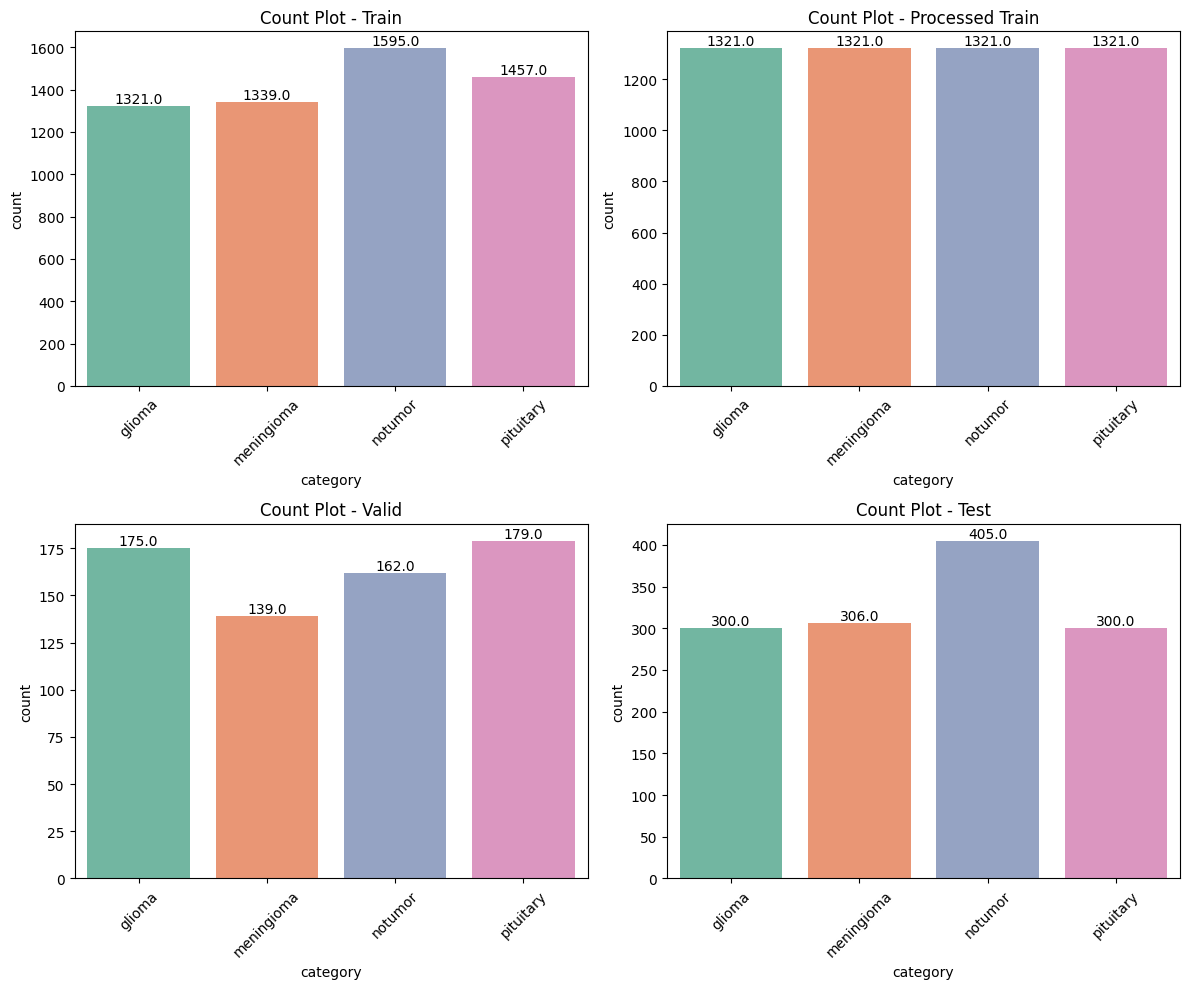

In [38]:

CATEGORIES =["glioma", "meningioma", "notumor", "pituitary"]
# Define a function to create subplots with count plots for different categories
def plot_countplots(train, processed_train, valid, test, categories):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create a 2x2 subplot layout

    datasets = [train, processed_train, valid, test]
    dataset_names = ['Train', 'Processed Train', 'Valid', 'Test']

    for i, ax in enumerate(axes.flatten()):
        sns.countplot(data=datasets[i], x='category', ax=ax, palette= "Set2")
        ax.set_title(f'Count Plot - {dataset_names[i]}')
        ax.set_xticklabels(categories, rotation=45)  # Set category names on x-axis
        
        # Add annotations (counts) on top of each bar
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

plot_countplots(trainset, training, validing, testing, CATEGORIES)


<h2> 🎃 Image Visualization</h2>


In [40]:
def read_img(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img


**📌About Code:**

`grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05):` Creates a grid layout of subplots (4 rows, 4 columns) within the figure with padding between axes set to 0.05.

`for category_id, category in enumerate(CATEGORIES)::` Loops through each category in the list CATEGORIES using its index (category_id) and value (category).

`for filepath in training[training['category']== category]['file'].values[:NUM_OF_CATEGORIES]::` Loops through a subset of image file paths for the current category (limited by NUM_OF_CATEGORIES) in the training dataset.

`ax = grid[i]:` Gets the current subplot (ax) from the grid using the index i.

`img = read_img(filepath, (WIDTH,HEIGHT)):` Reads and loads the image using a function read_img() (not shown) with specified width and height.

`ax.imshow(img/255.0):` Displays the image on the current subplot (ax) after normalizing pixel values to the range [0,1].

`ax.axis('on'):` Turns on the axes for the subplot.

`if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1::` Checks if the current subplot is the last subplot in a row.

`ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center'):` Adds text to the subplot indicating the category label based on the filepath split.

`i+=1:` Increments the counter variable i to move to the next subplot in the grid.


<h3> ⛳Training Image Data </h3>

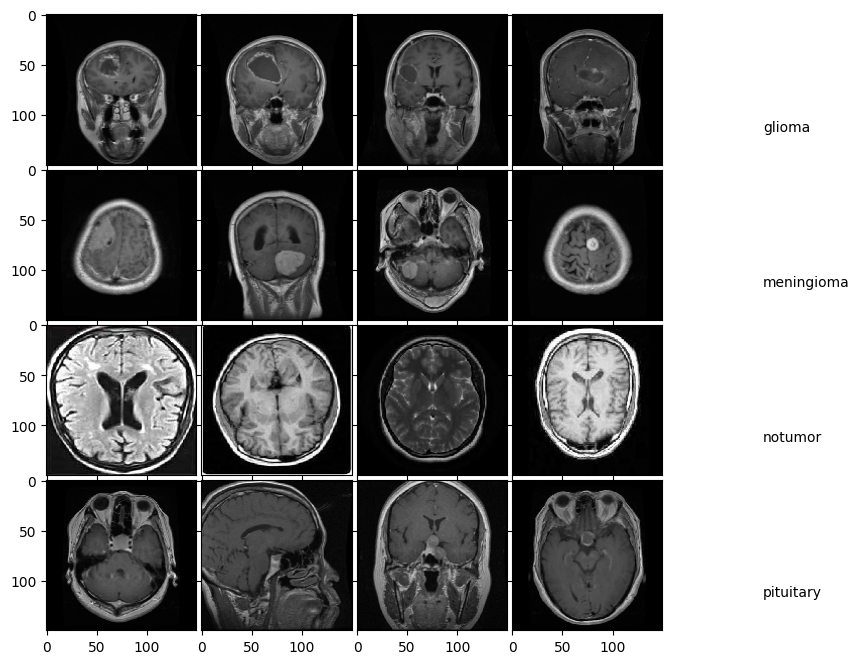

In [41]:

fig = plt.figure(1, figsize=(8, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
i = 0

for category_id, category in enumerate(CATEGORIES):
    for filepath in training[training['category'] == category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.0)
        ax.axis('on')
        if i % NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment='center')
        i += 1

plt.show()

<h3> ⛳ Testing Image Data </h3>

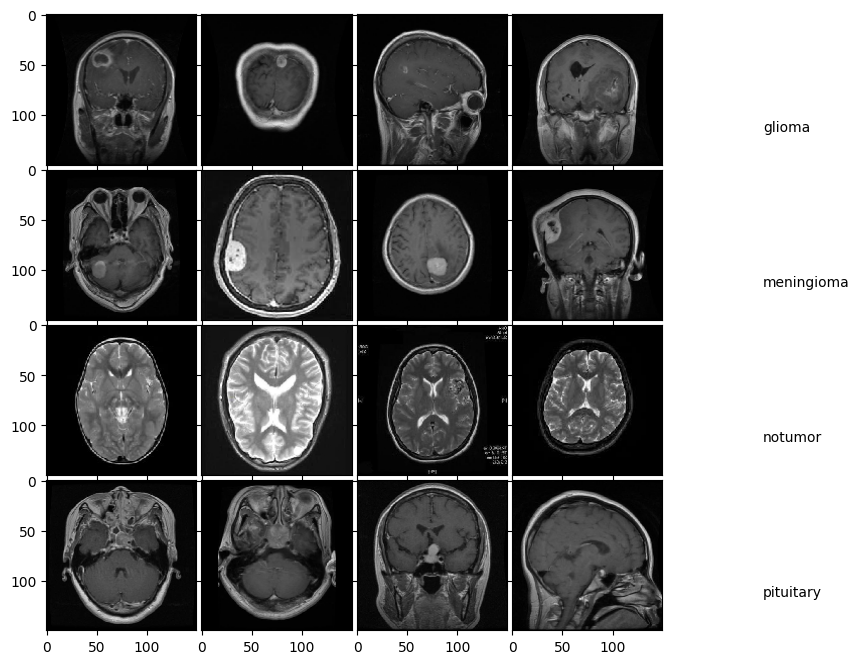

In [42]:
fig = plt.figure(1, figsize=(8,8))
#use of mpl ImageGrid toolkits for visualization
grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05)
i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in testing[testing['category']== category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH,HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('on')
        if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center')
        i+=1
    
plt.show() 

<h3> ⛳ Validating Image Data </h3>

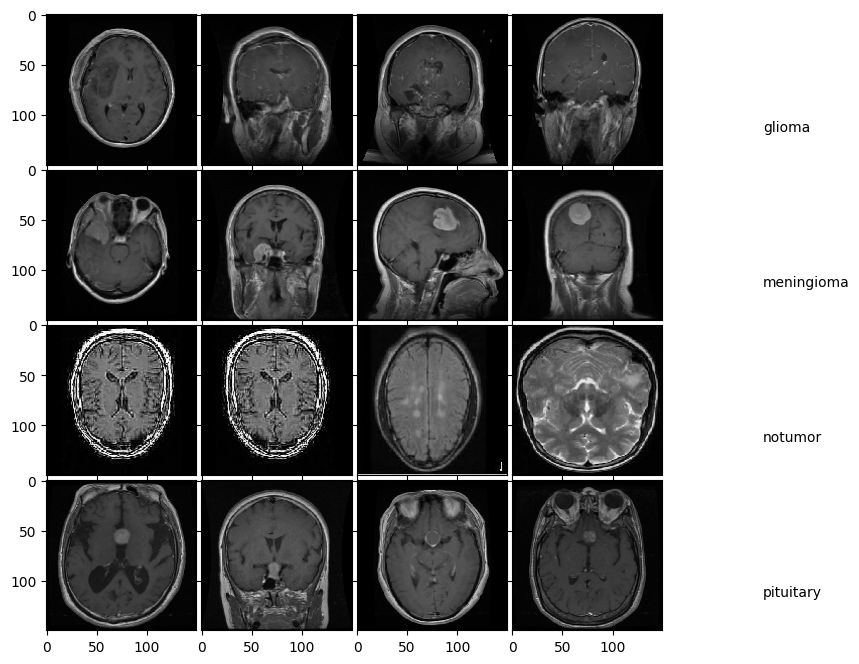

In [43]:
fig = plt.figure(1, figsize=(8,8))
#use of mpl ImageGrid toolkits for visualization
grid= ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.05)
i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in validing[validing['category']== category]['file'].values[:NUM_OF_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH,HEIGHT))
        ax.imshow(img/255.0)
        ax.axis('on')
        if i%NUM_OF_CATEGORIES == NUM_OF_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[-2], verticalalignment ='center')
        i+=1
    
plt.show() 

# 🏄 IMAGE DATA GENERATION FOR AUGMENTATION

**Image data augmentation** diversifies and expands **training datasets**, enhancing model performance by mitigating overfitting and improving generalization. By exposing models to various image alterations like **rotations, flips, and brightness changes**, it cultivates robustness to real-world scenarios. This technique helps balance class distributions and **trains models** to better handle diverse environmental factors, contributing to more reliable and effective predictions in **computer vision** tasks.

### 👾 Data Augmentation and Generation

In [45]:
def prepare_the_datasets(train_dataframe, valid_dataframe, x_columns, y_column, batch_size, image_size):  
    # Define parameters for ImageDataGenerator for train and validation
    train_image_data_generator = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values to [0,1]
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_image_data_generator = ImageDataGenerator(
        rescale=1./255  # Rescale pixel values to [0,1]
    )

    # Create image data generators for train and validation
    train_generator = train_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=train_dataframe,
        shuffle=True,
        x_col=x_columns,
        y_col=y_column,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode='categorical'  # For categorical labels
    )

    val_generator = val_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=valid_dataframe,
        shuffle=True,
        x_col=x_columns,
        y_col=y_column,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode='categorical'  # For categorical labels
    )
    return train_generator, val_generator

In [46]:
train_dataframe = training
valid_dataframe = testing
x_columns = 'file'
y_column = 'category'
batch_size = 64
image_size = 224

train_data_gen, validation_data_gen = prepare_the_datasets(train_dataframe, valid_dataframe, x_columns, y_column, batch_size, image_size)

Found 5284 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# 😼 BUILD MODEL WITH InceptionV3

In [ ]:
# Image_size=229,229,3
# pre_trained_model=keras.applications.InceptionV3(
#     include_top=False,
#     weights="imagenet",
#     input_shape=Image_size)

**📌note:** 

1. Freezing the convolutional layers in a pre-trained model like InceptionV3 prevents them from being updated during training.
2. Freezing can restrict the model's ability to fine-tune lower layers, which might be beneficial for some tasks or datasets with similar features.

In [ ]:
# # Freeze the convolutional layers to prevent them from being trained
# for layer in pre_trained_model.layers:
#     layer.trainable = False

**📌note: Some Basic of Neural Network**

`Flatten:` Converts multidimensional data into a flat, 1D array for fully connected layers.

`Dense:` Fully connected layer where each neuron connects to every neuron in the previous layer.

`BatchNormalization:` Normalizes layer inputs, aiding faster training by reducing internal covariate shift.

`Dropout:` During training, randomly deactivates neurons to prevent overfitting.

`No Dropout in Output Layer:` Dropout is typically omitted in the output layer to avoid interference with final predictions.

`Dropout Range:` Typically, dropout rates range between 0.1 to 0.5, where 0.5 means dropping half the neurons during training. Optimal rates vary by dataset and architecture.

In [ ]:
# x= pre_trained_model.output
# x= Flatten()(x)
# x = Dense(2048, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# x = Dense(1024, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.4)(x)
# output = Dense(4, activation='softmax')(x) 

**📌note:** This code segment creates a classification model using MobileNetV2 by flattening the higher-dimensional output, adding fully connected layers with ReLU activation, applying batch normalization, and using dropout for regularization, ultimately generating a softmax output with 4 categories.

In [ ]:
# custom_model= Model(inputs=pre_trained_model.input, outputs= output)

In [48]:
# load model 
from tensorflow.keras.models import load_model

# Đường dẫn đến mô hình đã lưu
model_path = '/kaggle/input/inceptionv3/tensorflow2/inceptionv3_hehe/1/Custom_model_InceptionV3.h5'

# Tải mô hình
custom_model = load_model(model_path)

# Hiển thị kiến trúc của mô hình để xác minh
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 229, 229, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 114, 114, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 114, 114, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 114, 114, 32)         0         ['batch_normalization[0][0

**📌note:** This line constructs the final neural network model by specifying the input and output layers, creating an instance of the model with the defined architecture using the MobileNetV2 backbone.

# 🌱 MODEL SUMMARY

In [ ]:
custom_model.summary()

**📌note:** This information shows that the machine learning model has a total of about 147.8 million settings that it learns from the data. Among these, around 147.8 million settings are adjustable during training, taking up about 563.76 megabytes of space. The remaining 6,104 settings, taking up about 23.84 kilobytes, are fixed and not adjusted during training. 

# 🎯 PLOT MODEL

# 🐥 MODEL COMPILE, TENSORBOARD, CHECKPOINT, REDUCE_LR

`Model Compile:` Configuration of a model with loss functions, optimizers, and metrics to prepare it for training.

`TensorBoard:` Visualization tool used to analyze and monitor machine learning models' performance through interactive graphs and summaries.

`Checkpoint:` Saving mechanism that captures the model's weights, allowing resuming training or loading the model for later use.

`Reduce_LR:` Technique to dynamically decrease the learning rate during training to facilitate convergence and prevent overshooting of the optimal solution.

In [ ]:
#Compile Model
custom_model.compile(loss='categorical_crossentropy',
               optimizer =tf.keras.optimizers.RMSprop(learning_rate=.0001),
               metrics=["accuracy"])

tensorboard= TensorBoard(log_dir="logs")
checkpoint= ModelCheckpoint("Custom_model_InceptionV3.h5",
                           monitor="val_loss",
                           mode="min",
                           save_best_only=True,
                           verbose=1)

early_stopping_callback= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0,
                                                         patience=3,
                                                         verbose=1,
                                                         restore_best_weights=True)

reduce_lr_callback= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                        factor=0.3,
                                                        patience=2,
                                                        verbose=1,
                                                        min_delta=0.00001)

CALLBACKS=[tensorboard, early_stopping_callback,checkpoint, reduce_lr_callback]

# 🌌 MODEL TRAINING

In [ ]:
# Calculate steps per epoch and validation steps
#train_steps = len(train_data_gen) // batch_size
#validation_steps = len(validation_data_gen) // batch_size
nb_train_samples=5284 
nb_validation_samples= 1311
epochs= 15
batch_size= 64
history= custom_model.fit(train_data_gen,
                   steps_per_epoch= nb_train_samples//batch_size,
                   epochs= epochs,
                   callbacks=CALLBACKS,
                   validation_data= validation_data_gen,
                   validation_steps= nb_validation_samples//batch_size,
                   shuffle= True)

# 👻 MODEL EVALUATION

In [49]:
train_score= custom_model.evaluate(train_data_gen)
print("\nWe have training loss {:.3f}% and training accuracy {:.3f}% after evaluation."
      .format(train_score[0]*100, train_score[1]*100))

83/83 [==============================] - 94s 1s/step - loss: 0.1636 - accuracy: 0.9434

We have training loss 16.359% and training accuracy 94.341% after evaluation.


In [50]:
val_score= custom_model.evaluate(validation_data_gen)
print("\nWe have validation loss {:.3f}% and validation accuracy {:.3f}% after evaluation."
      .format(val_score[0]*100, val_score[1]*100))

21/21 [==============================] - 11s 510ms/step - loss: 0.2280 - accuracy: 0.9237

We have validation loss 22.800% and validation accuracy 92.372% after evaluation.


# 🍧 ACCURACY, LEARNING RATE AND LOSS PLOT

In [51]:
def accuracy_lr_loss_plot():
    fig = plt.figure(figsize=(15,6))
    
    plt.subplot(131)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'go--', label = "val_accuracy")
    plt.title("Training Data Accuracy Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(132)
    plt.plot(history.history['lr'], 'bo--', label = 'learning Rate')
    plt.title("Learning Rate Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Learning Rate")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(133)
    plt.plot(history.history['loss'], 'bo--', label = 'loss')
    plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
    plt.title("Training Data Loss Measurements")
    plt.xlabel("No of Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()

NameError: name 'history' is not defined

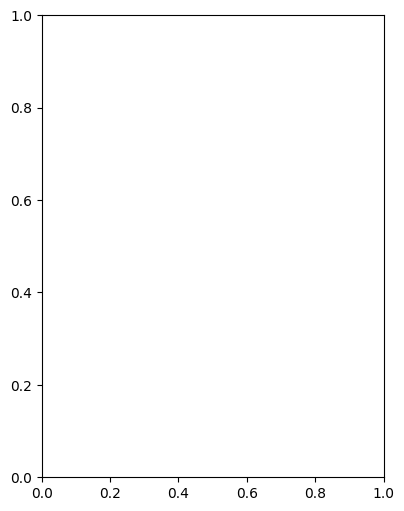

In [52]:
accuracy_lr_loss_plot()

# 😲 MODEL PREDICTION WITH VALIDATION(UNSEEN DATA)

In [53]:
def prepare_test_data(test_dataframe, x_columns, batch_size, image_size):  
    # Define parameters for ImageDataGenerator for train and validation

    test_image_data_generator = ImageDataGenerator(
        rescale=1./255  # Rescale pixel values to [0,1]
    )
    
    test_generator = test_image_data_generator.flow_from_dataframe(
        batch_size=batch_size,
        dataframe=test_dataframe,
        shuffle=False,
        x_col=x_columns,
        y_col=None,
        target_size=(image_size, image_size),  # Set the target size for images
        class_mode=None  # For categorical labels
    )
    return test_generator

In [54]:
#testing columns details
testing.columns

Index(['file', 'category_id', 'category'], dtype='object')

In [55]:
#test images preprocessing
test_processed_images = prepare_test_data(validing,'file', 32, 224)

Found 655 validated image filenames.


In [56]:
# Make predictions for images using the model
predictions = custom_model.predict(test_processed_images, steps=len(testing) // 32 + 1)

41/41 [==============================] - 7s 119ms/step


In [57]:
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1,

In [59]:
#validing dataset to create new dataframe
target_and_predict = validing.copy()

In [60]:
#add column for predicted value
target_and_predict['predicted_classes'] = predicted_classes

In [61]:
#target_and_predict dataframe
target_and_predict

,file,category_id,category,predicted_classes
0,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma,0
1,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma,0
2,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma,0
3,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma,0
4,/kaggle/input/mri-image-based-brain-tumor-clas...,0,glioma,0
...,...,...,...,...
650,/kaggle/input/mri-image-based-brain-tumor-clas...,3,pituitary,3
651,/kaggle/input/mri-image-based-brain-tumor-clas...,3,pituitary,3
652,/kaggle/input/mri-image-based-brain-tumor-clas...,3,pituitary,3
653,/kaggle/input/mri-image-based-brain-tumor-clas...,3,pituitary,3


# 😃 TESTING ACCURACY

In [62]:
# Calculate accuracy
accuracy = accuracy_score(target_and_predict['category_id'], target_and_predict['predicted_classes'])

print(f"\nWe have test accuracy {accuracy * 100:.4f}% after test images evaluation.")


We have test accuracy 94.8092% after test images evaluation.


# 🏣 AUC and ROC CURVE

The code generates an ROC curve for unique classes by:

* Extracting unique classes present in both true labels and predicted classes.
* Binarizing labels and predictions for these unique classes.
* Computing False Positive Rate (FPR) and True Positive Rate (TPR) for each class.
* Plotting the ROC curve for each unique class, displaying class-specific areas under the curve (AUC) in a single plot.


In [63]:
# find the column with unique values
unique_values = target_and_predict['category_id'].unique()

result = target_and_predict.groupby('category_id').first()
result

,file,category,predicted_classes
category_id,,,
0,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,0
1,/kaggle/input/mri-image-based-brain-tumor-clas...,meningioma,1
2,/kaggle/input/mri-image-based-brain-tumor-clas...,notumor,2
3,/kaggle/input/mri-image-based-brain-tumor-clas...,pituitary,3


In [65]:
result['category']

category_id
0        glioma
1    meningioma
2       notumor
3     pituitary
Name: category, dtype: object

++++++++++++++++++++ AUC and ROC Details ++++++++++++++++++++++++
Create ROC CURVE for Unique Classes


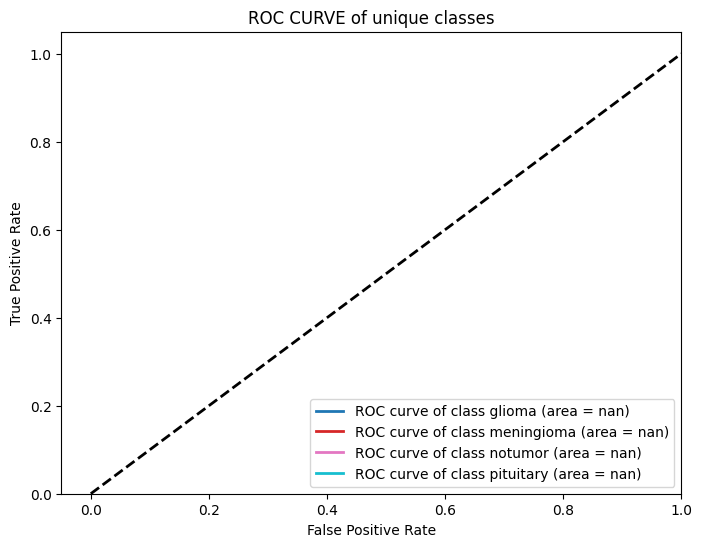

In [64]:
class_names = target_and_predict['category']
class_names = result['category']
true_labels = target_and_predict['category_id']
predicted_classes_int = target_and_predict['predicted_classes']

def auc_roc_curve():
    print("++++++++++++++++++++ AUC and ROC Details ++++++++++++++++++++++++")
    unique_classes = np.unique(np.concatenate((true_labels, predicted_classes_int), axis=None))

    y_test_bin = label_binarize(true_labels, classes=class_names)
    y_pred_bin = label_binarize(predicted_classes_int, classes=class_names)

    n_classes = len(class_names)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    print("=================================================================")
    print("Create ROC CURVE for Unique Classes")

    lw = 2
    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i, color, j, in zip(range(n_classes), colors(np.arange(n_classes)), class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {} (area = {:.3f})'.format(j, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE of unique classes')
    plt.legend(loc="lower right")
    plt.show()

auc_roc_curve()

# 😖 CONFUSION MATRIX DISPLAY


This code snippet achieves the following:

* Mapping Creation: Constructs a dictionary mapping category IDs to their corresponding names from the DataFrame.
* Replacement: Converts numeric values in 'category_id' and 'predicted_classes' columns to their respective names using the mapping dictionary.
* Report Generation: Utilizes the modified DataFrame to generate a classification report, replacing numeric values with category names, demonstrating the classification performance.

In [66]:
# Replace these with your actual column names
category_id_column = 'category_id'
predicted_classes_column = 'predicted_classes'
category_name_column = 'category'

# Create a mapping dictionary from category_id to category_name
id_to_name_mapping = dict(zip(target_and_predict[category_id_column], target_and_predict[category_name_column]))
print(f"id_to_name_mapping:\n{id_to_name_mapping}")
# Replace numeric values in 'category_id' and 'predicted_classes' columns with their names
target_and_predict['category_id'] = target_and_predict['category_id'].map(id_to_name_mapping)
target_and_predict['predicted_classes'] = target_and_predict['predicted_classes'].map(id_to_name_mapping)

# Generate classification report with names instead of numeric values
report = classification_report(
    target_and_predict['category_id'],
    target_and_predict['predicted_classes']
)

print(report)

id_to_name_mapping:
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
              precision    recall  f1-score   support

      glioma       0.96      0.95      0.95       175
  meningioma       0.93      0.89      0.91       139
     notumor       0.99      0.98      0.98       162
   pituitary       0.92      0.96      0.94       179

    accuracy                           0.95       655
   macro avg       0.95      0.95      0.95       655
weighted avg       0.95      0.95      0.95       655



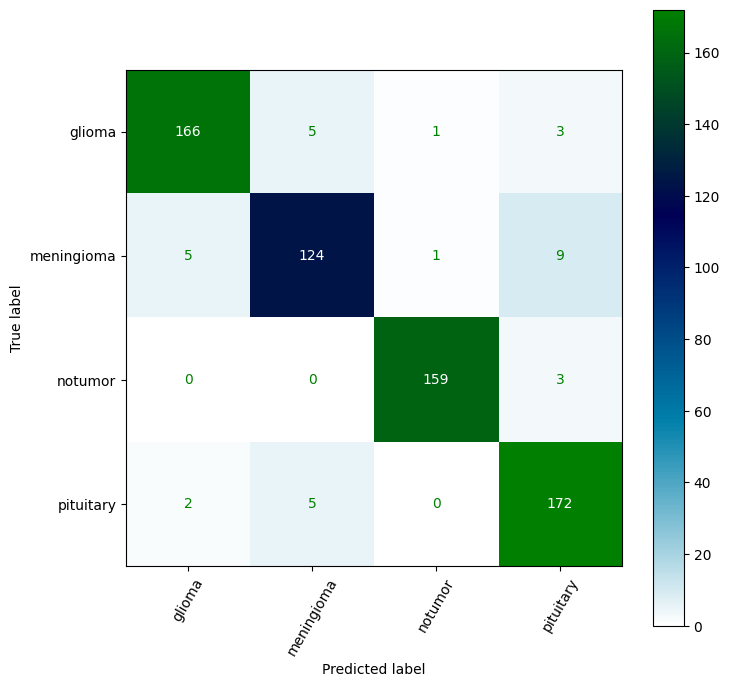

In [67]:
# Generate confusion matrix
conf_matrix = confusion_matrix(
    target_and_predict['category_id'],
    target_and_predict['predicted_classes']
)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(id_to_name_mapping.values()))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='ocean_r',ax=ax,xticks_rotation=60)
plt.show()


# 👿 MISCLASSIFIED IMAGES 

The provided code snippet performs the following:

* Data Selection: Extracts misclassified samples by comparing the 'category_id' and 'predicted_classes' columns.
* Visualization: Displays a grid of misclassified images along with their actual and predicted labels.
* Adjustable Display: Sets the number of misclassified images to exhibit in a 3x3 grid and showcases them with their respective labels using Matplotlib.

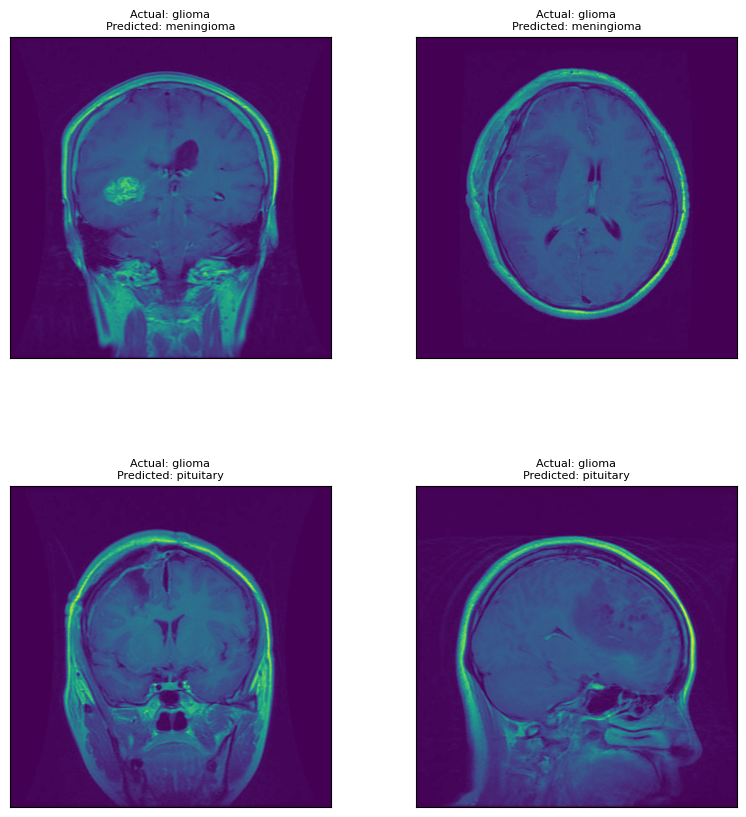

In [68]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image

# Assuming 'target_and_predict' is your DataFrame
# and it has been defined somewhere above this code.

# Replace these with your actual column names
image_path_column = 'file'
category_id_column = 'category_id'
predicted_classes_column = 'predicted_classes'

# Filter misclassified samples from the DataFrame
misclassified = target_and_predict[target_and_predict[category_id_column] != target_and_predict[predicted_classes_column]]

# Define the number of images to display
num_images_to_display = 4  # Adjust based on your need or available space

# Adjust the number of images to display based on the actual number of misclassified images
num_images_to_display = min(len(misclassified), num_images_to_display)

# Create a GridSpec with appropriate dimensions
cols = 2  # You can adjust the number of columns based on your display preference
rows = (num_images_to_display + cols - 1) // cols  # Calculate rows needed

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(rows, cols)
gs.update(wspace=0.1, hspace=0.4)

for i, (_, row) in enumerate(misclassified.head(num_images_to_display).iterrows()):
    img_path = row[image_path_column]
    actual_label = row[category_id_column]
    predicted_label = row[predicted_classes_column]

    img = Image.open(img_path)
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}', fontsize=8)

plt.tight_layout()
plt.show()

# 👽 MISCLASSIFIED IMAGE PATH


The provided code performs the following operations:

* Data Selection: Filters misclassified samples by comparing 'category_id' and 'predicted_classes' columns.
* Extraction: Retrieves a DataFrame containing misclassified samples with columns for image paths, actual categories, and predicted categories.
* Display: Prints a DataFrame displaying misclassified samples along with their respective image paths, actual categories, and predicted categories.

In [69]:
# Replace these with your actual column names
image_path_column = 'file'
category_id_column = 'category_id'
predicted_classes_column = 'predicted_classes'

# Filter misclassified samples and extract indices with corresponding image paths
misclassified_samples = target_and_predict[target_and_predict[category_id_column] != target_and_predict[predicted_classes_column]]
misclassified_indices_with_image_paths = misclassified_samples[[image_path_column, category_id_column, predicted_classes_column]]

print("Misclassified Samples with Image Paths:")
misclassified_indices_with_image_paths

Misclassified Samples with Image Paths:


,file,category_id,predicted_classes
15,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,meningioma
16,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,meningioma
88,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,pituitary
98,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,pituitary
110,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,meningioma
130,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,pituitary
140,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,meningioma
142,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,notumor
148,/kaggle/input/mri-image-based-brain-tumor-clas...,glioma,meningioma
181,/kaggle/input/mri-image-based-brain-tumor-clas...,meningioma,pituitary


In [70]:
import matplotlib.pyplot as plt

# Trích xuất thông tin từ dict history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Định nghĩa số lượng epochs
epochs = range(1, len(acc) + 1)

# Tạo biểu đồ accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 hàng, 2 cột, vị trí thứ 1
plt.plot(epochs, acc, 'bo-', label='Training Acc')
plt.plot(epochs, val_acc, 'go-', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Tạo biểu đồ loss
plt.subplot(1, 2, 2)  # 1 hàng, 2 cột, vị trí thứ 2
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'history' is not defined

1/1 [==============================] - 1s 702ms/step
[[7.6813650e-01 1.5951626e-01 4.4722565e-05 7.2302610e-02]]
Predicted Class: glioma, Probability: 0.77


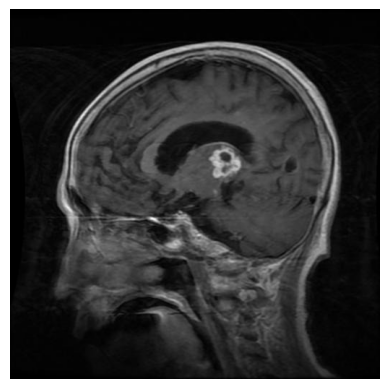

In [71]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the custom model (Assuming it's already loaded, this line is just a placeholder)
# custom_model = load_model('path_to_your_model.h5')

# Define the categories
CATEGORIES = ["glioma", "meningioma", "notumor", "pituitary"]

# Path to the image
image_path = '/kaggle/input/mri-image-based-brain-tumor-classification/MRI Image Dataset for Brain Tumor/Training/glioma/Tr-gl_0025.jpg'

# Read and preprocess the image
img = image.load_img(image_path, target_size=(229, 229))  # Adjust the size according to the model's requirement
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch of size 1
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Predict using the model
predictions = custom_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class_name = CATEGORIES[predicted_class_index]
predicted_probability = np.max(predictions)

# Print predictions
print(predictions)
print(f'Predicted Class: {predicted_class_name}, Probability: {predicted_probability:.2f}')

# Display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()

# Conclusion
**Please feel free to ask in the comment section if you have any confusion or questions.**

**Here are some of the contributions I've made on Kaggle:**
1. [Pie Charts in Python](https://www.kaggle.com/code/alsaniipe/pie-charts-in-python)
1. [Scatter plots with Plotly Express](https://www.kaggle.com/code/alsaniipe/scatter-plots-with-plotly-express)
1. [X-ray Image Classification using Transfer Learning](https://www.kaggle.com/code/alsaniipe/x-ray-image-classification-using-transfer-learning)
1. [Flowers Classification by Using VGG16 Model 🎉🎉](https://www.kaggle.com/code/alsaniipe/flowers-classification-by-using-vgg16-model)
1. [Car Brand Prediction's by Using ResNet50 Model](https://www.kaggle.com/code/alsaniipe/car-brand-prediction-s-by-using-resnet50-model)
1. [Image Preprocessing-Morpological Analysis & Kernel](https://www.kaggle.com/code/alsaniipe/image-preprocessing-morpological-analysis-kernel)
1. [Image Similarity Index (SSIM analysis )](https://www.kaggle.com/code/alsaniipe/image-similarity-index-ssim-analysis)
1. [Image Preprocessing- Image Transformation & OpenCV](https://www.kaggle.com/code/alsaniipe/image-preprocessing-image-transformation-opencv)